<a href="https://colab.research.google.com/github/ravishanilneth/Early-Detection-of-Alzheimer-s-Disease-Using-Explainable-AI-Powered-Deep-Learning/blob/main/Multi_Feature_Model_with_XAI_and_Web_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import cv2
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the MRI image
mri_image_path = "D:/KDU/final year research/Alzhimer's disease early detection/SUPIRI DATASETS/final/Mild Dementia/IMG_OAS1_0028_MR1/OAS1_0028_MR1_mpr-1_anon.nii_registered.nii"
mri_image = nib.load(mri_image_path)

# Get the image data
mri_data = mri_image.get_fdata()

# Check the shape of the image
print(f"Image shape: {mri_data.shape}")

# Check if the image has more than 1 channel (RGB vs grayscale)
if len(mri_data.shape) == 3:
    print("The image is grayscale (single channel).")
elif len(mri_data.shape) == 4 and mri_data.shape[-1] == 3:
    print("The image is RGB (3 channels).")
else:
    print("The image format is unexpected.")

Image shape: (128, 128, 128)
The image is grayscale (single channel).


In [ ]:
# Constants
IMG_SIZE = 128
NUM_SLICES = 10
CHANNELS = 3  # RGB
SLICE_SELECTION = 'middle'
CLASSES = ['Non Demented', 'Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']

# Load and preprocess a NIfTI image
def load_nifti_image(file_path):
    img = nib.load(file_path)
    img_data = img.get_fdata()

    # Normalize the image
    img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

    if SLICE_SELECTION == 'middle':
        slice_index = img_data.shape[2] // 2
        img_slice = img_data[:, :, slice_index]
        img_slice = cv2.resize(img_slice, (IMG_SIZE, IMG_SIZE))
        img_slice_rgb = np.stack((img_slice,) * 3, axis=-1)
        return img_slice_rgb
    elif SLICE_SELECTION == 'custom':
        slices = []
        indices = np.linspace(0, img_data.shape[2] - 1, NUM_SLICES).astype(int)
        for i in indices:
            img_slice = cv2.resize(img_data[:, :, i], (IMG_SIZE, IMG_SIZE))
            img_slice_rgb = np.stack((img_slice,) * 3, axis=-1)
            slices.append(img_slice_rgb)
        return np.array(slices)

# Preprocess tabular dataset
data = pd.read_csv("D:/KDU/final year research/AD ML files/datasets/oasis_cross-sectional.csv")
data.drop(['Hand', 'Delay', 'CDR', 'eTIV', 'ASF', 'M/F', 'SES'], axis=1, inplace=True)
data.dropna(subset=['Group'], inplace=True)
data['MMSE'].fillna(data['MMSE'].median(), inplace=True)
data['Educ'].fillna(data['Educ'].mode()[0], inplace=True)

# Encode labels and scale features
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['Group'])
data['Educ'] = LabelEncoder().fit_transform(data['Educ'].astype(str))
scaler = MinMaxScaler()
data['MMSE'] = scaler.fit_transform(data[['MMSE']])

X_tab = data[['Age', 'Educ', 'MMSE', 'nWBV']]
y = to_categorical(y_encoded, num_classes=len(CLASSES))

# Load MRI data
def prepare_mri_data(main_dir, classes):
    patient_paths = []
    labels = []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(main_dir, class_name)
        for patient_folder in os.listdir(class_dir):
            patient_dir = os.path.join(class_dir, patient_folder)
            if not os.path.isdir(patient_dir):
                continue
            nifti_files = [os.path.join(patient_dir, f) for f in os.listdir(patient_dir)
                           if f.endswith('.nii') or f.endswith('.nii.gz')]
            patient_paths.append(nifti_files)
            labels.append(label)
    return patient_paths, labels

main_dir = "D:/KDU/final year research/Alzhimer's disease early detection/SUPIRI DATASETS/final"
mri_patient_paths, mri_labels = prepare_mri_data(main_dir, CLASSES)

In [ ]:
# Extract patient IDs from the tabular data
tabular_ids = data['ID'].str.extract(r'(OAS1_\d{4}_MR1)')[0].values

# Extract patient IDs from MRI paths
mri_ids = [os.path.basename(paths[0]).split('_')[1] for paths in mri_patient_paths]
standardized_mri_ids = ['OAS1_' + id + '_MR1' for id in mri_ids]

# Ensure both datasets are sorted by ID for proper alignment
sorted_tabular_indices = np.argsort(tabular_ids)
sorted_mri_indices = np.argsort(standardized_mri_ids)

# Ensure X_tab is a numpy array if not already
X_tab = np.array(X_tab)

# Sort the tabular and MRI data by their IDs using numpy indexing
X_tab_sorted = X_tab[sorted_tabular_indices]
y_sorted = y[sorted_tabular_indices]

# Correctly sorting mri_patient_paths using the list of indices
mri_patient_paths_sorted = [mri_patient_paths[i] for i in sorted_mri_indices]

# Data Augmentation for MRI images
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_mri_images(mri_images, tabular_data, labels, num_augmented=5):
    augmented_images = []
    augmented_tabular = []
    augmented_labels = []

    for img, tab, label in zip(mri_images, tabular_data, labels):
        # Augment the entire MRI by applying augmentation to each slice independently
        for _ in range(num_augmented):
            augmented_patient_slices = []
            for slice_img in img:
                slice_img = np.expand_dims(slice_img, axis=0)
                it = datagen.flow(slice_img, batch_size=1)
                augmented_img = it.next()[0].astype(np.float32)
                augmented_patient_slices.append(augmented_img)

            # Append the augmented MRI scan
            augmented_images.append(np.array(augmented_patient_slices))
            augmented_tabular.append(tab)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_tabular), np.array(augmented_labels)

# Now load and sort MRI images using the sorted paths
def load_images(paths):
    images = []
    for patient_files in paths:
        patient_slices = []
        for file_path in patient_files:
            image_data = load_nifti_image(file_path)
            patient_slices.append(image_data)

        patient_slices = np.array(patient_slices)

        if len(patient_slices) < NUM_SLICES:
            padding = np.zeros((NUM_SLICES - len(patient_slices), IMG_SIZE, IMG_SIZE, CHANNELS))
            patient_slices = np.concatenate((patient_slices, padding), axis=0)
        else:
            patient_slices = patient_slices[:NUM_SLICES]

        images.append(patient_slices)

    return np.array(images, dtype=np.float32)

In [ ]:
# Load sorted MRI images
X_mri = load_images(mri_patient_paths_sorted)

# Now X_tab_sorted and X_mri are aligned
X_tab = X_tab_sorted
y = y_sorted

# Apply augmentation
X_mri_aug, X_tab_aug, y_aug = augment_mri_images(X_mri, X_tab, y_sorted)

In [ ]:
# Use augmented data for splitting
X_mri_train, X_mri_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_mri_aug, X_tab_aug, y_aug, test_size=0.2, stratify=y_aug
)
X_mri_train, X_mri_val, X_tab_train, X_tab_val, y_train, y_val = train_test_split(
    X_mri_train, X_tab_train, y_train, test_size=0.1, stratify=y_train
)

# Print shapes to verify correctness
print(f"Train MRI shape: {X_mri_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation MRI shape: {X_mri_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test MRI shape: {X_mri_test.shape}, Test labels shape: {y_test.shape}")
print(f"Train tabular shape: {X_tab_train.shape}, Validation tabular shape: {X_tab_val.shape}, Test tabular shape: {X_tab_test.shape}")

Train MRI shape: (792, 10, 128, 128, 3), Train labels shape: (792, 4)
Validation MRI shape: (88, 10, 128, 128, 3), Validation labels shape: (88, 4)
Test MRI shape: (220, 10, 128, 128, 3), Test labels shape: (220, 4)
Train tabular shape: (792, 4), Validation tabular shape: (88, 4), Test tabular shape: (220, 4)


In [ ]:
# Assuming `mri_patient_paths_sorted` contains paths with patient IDs and `X_tab_sorted` corresponds to tabular data with matching IDs

def verify_data_alignment(mri_patient_paths, tabular_ids):
    # Extract patient IDs from MRI file paths
    mri_ids = [os.path.basename(paths[0]).split('_')[1] for paths in mri_patient_paths]
    standardized_mri_ids = ['OAS1_' + id + '_MR1' for id in mri_ids]

    # Extract patient IDs from tabular data
    tabular_patient_ids = tabular_ids

    # Ensure both are sorted for direct comparison
    sorted_mri_ids = np.array(standardized_mri_ids)
    sorted_tabular_ids = np.array(tabular_patient_ids)

    # Check for mismatches
    mismatched_ids = np.setdiff1d(sorted_mri_ids, sorted_tabular_ids)
    if len(mismatched_ids) > 0:
        print(f"Mismatched MRI IDs not present in tabular data: {mismatched_ids}")
        return False

    mismatched_tabular_ids = np.setdiff1d(sorted_tabular_ids, sorted_mri_ids)
    if len(mismatched_tabular_ids) > 0:
        print(f"Mismatched tabular IDs not present in MRI data: {mismatched_tabular_ids}")
        return False

    print("All MRI data and tabular data match correctly.")
    return True

# Verify if MRI data and tabular data are aligned
alignment_status = verify_data_alignment(mri_patient_paths_sorted, data['ID'].str.extract(r'(OAS1_\d{4}_MR1)')[0].values)

if not alignment_status:
    print("Warning: There is a misalignment between MRI and tabular data. Please correct before proceeding.")
else:
    print("Proceeding with aligned MRI and tabular data.")

All MRI data and tabular data match correctly.
Proceeding with aligned MRI and tabular data.


In [ ]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, TimeDistributed, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

def create_simplified_hybrid_model(num_classes, img_size, num_slices, tabular_input_shape):
    # MRI data input
    mri_input = Input(shape=(num_slices, img_size, img_size, CHANNELS), name='mri_input')

    # Use ResNet50V2 model
    resnet_base = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, CHANNELS)
    )

    # Freeze most of the ResNet layers to prevent overfitting
    for layer in resnet_base.layers[:-20]:
        layer.trainable = False

    # Process MRI slices
    x = TimeDistributed(resnet_base)(mri_input)
    x = TimeDistributed(GlobalAveragePooling2D())(x)
    x = Flatten()(x)

    # Dense layer for initial MRI feature processing
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Tabular data input
    tabular_input = Input(shape=(tabular_input_shape,), name='tabular_input')

    # Processing for tabular data
    tab_x = Dense(64, activation='relu')(tabular_input)
    tab_x = Dropout(0.3)(tab_x)

    # Combine MRI and tabular features
    concatenated = Concatenate()([x, tab_x])

    # Final classification layers
    x = Dense(128, activation='relu')(concatenated)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)

    # Create model
    model = Model(inputs=[mri_input, tabular_input], outputs=output)

    return model

# Create and compile the model
num_classes = len(CLASSES)
tabular_input_shape = X_tab_train.shape[1]
hybrid_model = create_simplified_hybrid_model(num_classes, IMG_SIZE, NUM_SLICES, tabular_input_shape)

# Compile with simple settings
hybrid_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
# Train the model with class weights
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping

class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

history = hybrid_model.fit(
    [X_mri_train, X_tab_train],
    y_train,
    validation_data=([X_mri_val, X_tab_val], y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[
        ModelCheckpoint('best_hybrid_model_01.h5', monitor='val_accuracy', save_best_only=True, mode='max'),
        EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)
    ]
)

Epoch 1/10
25/25 [==============================] - 341s 11s/step - loss: 4.4653 - accuracy: 0.3523 - precision: 0.3550 - recall: 0.3447 - val_loss: 1.5145 - val_accuracy: 0.5682 - val_precision: 0.5632 - val_recall: 0.5568
Epoch 2/10
25/25 [==============================] - 293s 12s/step - loss: 3.2541 - accuracy: 0.4394 - precision: 0.4458 - recall: 0.4306 - val_loss: 1.0590 - val_accuracy: 0.5682 - val_precision: 0.5875 - val_recall: 0.5341
Epoch 3/10
25/25 [==============================] - 300s 12s/step - loss: 3.9723 - accuracy: 0.4583 - precision: 0.4607 - recall: 0.4444 - val_loss: 1.0538 - val_accuracy: 0.5795 - val_precision: 0.6216 - val_recall: 0.5227
Epoch 4/10
25/25 [==============================] - 305s 12s/step - loss: 2.7670 - accuracy: 0.5101 - precision: 0.5196 - recall: 0.5013 - val_loss: 0.9840 - val_accuracy: 0.6250 - val_precision: 0.6310 - val_recall: 0.6023
Epoch 5/10
25/25 [==============================] - 297s 12s/step - loss: 2.4152 - accuracy: 0.5152 - pr

In [ ]:
# Load the saved model weights
hybrid_model.load_weights('best_hybrid_model_01.h5')

# Evaluate the model
test_results = hybrid_model.evaluate(
    [X_mri_test, X_tab_test],
    y_test,
    verbose=1
)

# Print results
print(f'Test Loss: {test_results[0]:.4f}')
print(f'Test Accuracy: {test_results[1] * 100:.2f}%')
print(f'Test Precision: {test_results[2] * 100:.2f}%')
print(f'Test Recall: {test_results[3] * 100:.2f}%')

# Get predictions for confusion matrix
y_pred = hybrid_model.predict([X_mri_test, X_tab_test])
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Print confusion matrix
from sklearn.metrics import confusion_matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_classes, y_pred_classes))

7/7 [==============================] - 31s 4s/step - loss: 0.9364 - accuracy: 0.6955 - precision: 0.7122 - recall: 0.6636
Test Loss: 0.9364
Test Accuracy: 69.55%
Test Precision: 71.22%
Test Recall: 66.36%
7/7 [==============================] - 35s 5s/step

Confusion Matrix:
[[15  0  3  8]
 [ 0  2  0  0]
 [ 2  0 98 23]
 [ 1  0 30 38]]


7/7 [==============================] - 30s 4s/step


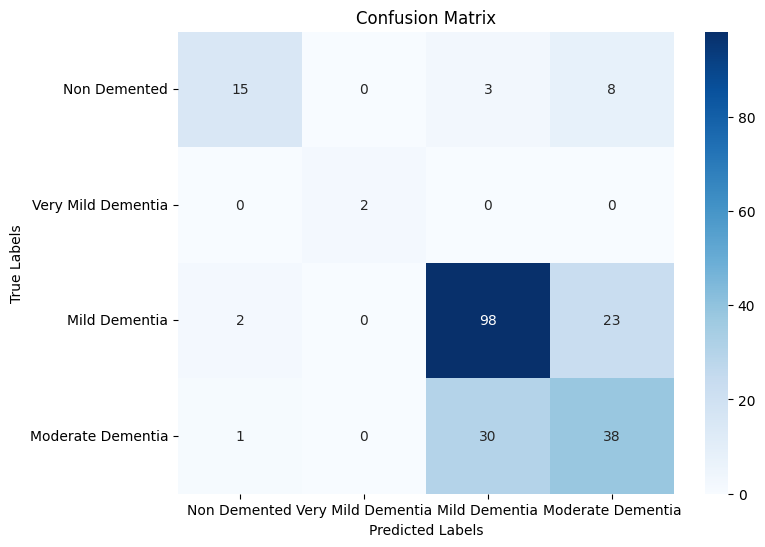

In [ ]:
# Create and display a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = np.argmax(hybrid_model.predict([X_mri_test, X_tab_test]), axis=1)
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CLASSES, yticklabels=CLASSES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

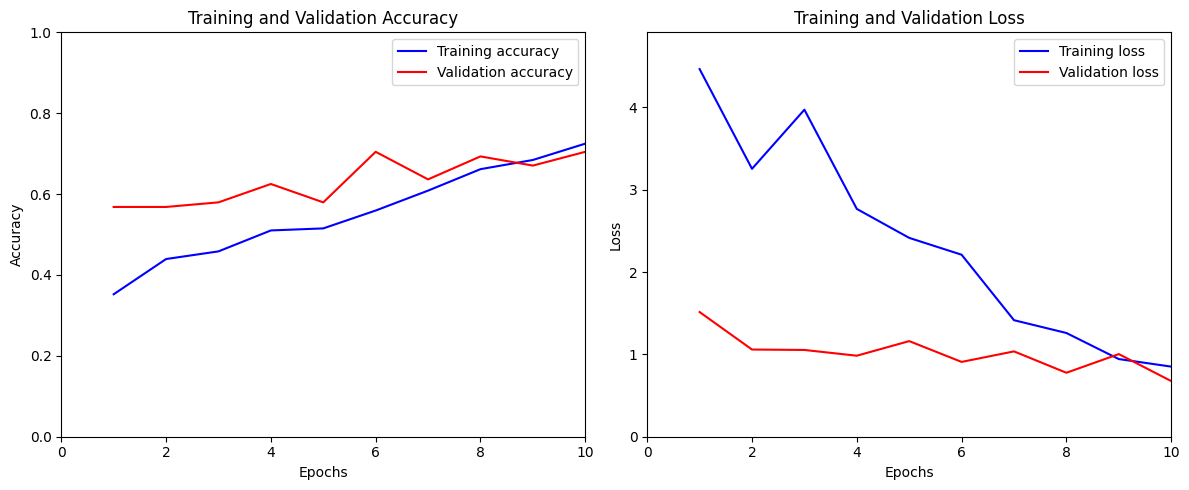

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plotting training and validation accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim(0, len(epochs))  # Ensure x-axis starts from 0
    plt.ylim(0, 1)            # Ensure y-axis (accuracy) starts from 0 and goes up to 1

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xlim(0, len(epochs))  # Ensure x-axis starts from 0
    plt.ylim(0, max(max(loss), max(val_loss)) * 1.1)  # Ensure y-axis (loss) starts from 0

    plt.tight_layout()
    plt.show()

# Plot learning curves
plot_learning_curves(history)

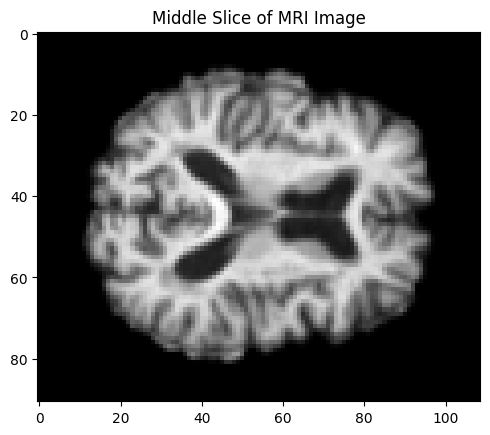

Shape of the 3D MRI image: (91, 109, 91)


In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def extract_middle_slice(mri_image_3d, axis=2):
    """
    Extracts the middle slice along a given axis from the 3D MRI image.

    :param mri_image_3d: 3D MRI image (shape: (128, 128, 128))
    :param axis: Axis along which to extract the middle slice (default is 2)
    :return: 2D middle slice
    """
    middle_index = mri_image_3d.shape[axis] // 2
    if axis == 0:
        return mri_image_3d[middle_index, :, :]
    elif axis == 1:
        return mri_image_3d[:, middle_index, :]
    else:
        return mri_image_3d[:, :, middle_index]

# Example usage
mri_image_path = "D:/KDU/final year research/Alzhimer's disease early detection/SUPIRI DATASETS/OASIS1/OASIS_MNI_Registered-main/OAS1_0028_MR1/OAS1_0028_MR1_mpr-1_anon.nii_registered.nii"
mri_image_3d = nib.load(mri_image_path).get_fdata()

# Extract the middle slice (along the third axis)
mri_slice_2d = extract_middle_slice(mri_image_3d, axis=2)

# Visualize the extracted slice
plt.imshow(mri_slice_2d, cmap='gray')
plt.title('Middle Slice of MRI Image')
plt.show()


# Check the shape of the original 3D MRI image
print(f"Shape of the 3D MRI image: {mri_image_3d.shape}")

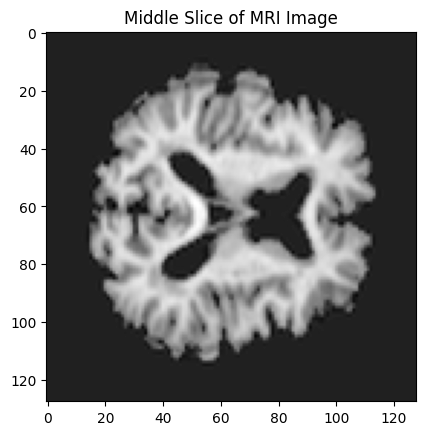

Shape of the 3D MRI image: (128, 128, 128)


In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def extract_middle_slice(mri_image_3d, axis=2):
    """
    Extracts the middle slice along a given axis from the 3D MRI image.

    :param mri_image_3d: 3D MRI image (shape: (128, 128, 128))
    :param axis: Axis along which to extract the middle slice (default is 2)
    :return: 2D middle slice
    """
    middle_index = mri_image_3d.shape[axis] // 2
    if axis == 0:
        return mri_image_3d[middle_index, :, :]
    elif axis == 1:
        return mri_image_3d[:, middle_index, :]
    else:
        return mri_image_3d[:, :, middle_index]

# Example usage
mri_image_path = "D:/KDU/final year research/Alzhimer's disease early detection/SUPIRI DATASETS/final/Mild Dementia/IMG_OAS1_0028_MR1/OAS1_0028_MR1_mpr-1_anon.nii_registered.nii"
mri_image_3d = nib.load(mri_image_path).get_fdata()

# Extract the middle slice (along the third axis)
mri_slice_2d = extract_middle_slice(mri_image_3d, axis=2)

# Visualize the extracted slice
plt.imshow(mri_slice_2d, cmap='gray')
plt.title('Middle Slice of MRI Image')
plt.show()


# Check the shape of the original 3D MRI image
print(f"Shape of the 3D MRI image: {mri_image_3d.shape}")

Enter the path to your MRI image: D:/KDU/final year research/Alzhimer's disease early detection/SUPIRI DATASETS/final/Mild Dementia/IMG_OAS1_0137_MR1/OAS1_0137_MR1_mpr-2_anon.nii_registered.nii
Enter Age: 87
Enter Education Status: 2
Enter MMSE score: 22
Enter nWBV: 0.672
1/1 [==============================] - 0s 421ms/step

Predicted Class: Mild Dementia
Class Probabilities:
Non Demented: 0.1699
Very Mild Dementia: 0.0173
Mild Dementia: 0.6920
Moderate Dementia: 0.1207


  0%|                                                                                         | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  0%|▍                                                                               | 10/2000 [00:02<09:49,  3.38it/s]

1/1 [==============================] - 3s 3s/step


  1%|▊                                                                               | 20/2000 [00:05<09:36,  3.44it/s]

1/1 [==============================] - 3s 3s/step


  2%|█▏                                                                              | 30/2000 [00:08<09:30,  3.45it/s]

1/1 [==============================] - 3s 3s/step


  2%|█▌                                                                              | 40/2000 [00:11<09:28,  3.45it/s]

1/1 [==============================] - 3s 3s/step


  2%|██                                                                              | 50/2000 [00:14<09:27,  3.44it/s]

1/1 [==============================] - 3s 3s/step


  3%|██▍                                                                             | 60/2000 [00:17<09:25,  3.43it/s]

1/1 [==============================] - 3s 3s/step


  4%|██▊                                                                             | 70/2000 [00:20<09:33,  3.36it/s]

1/1 [==============================] - 3s 3s/step


  4%|███▏                                                                            | 80/2000 [00:23<09:48,  3.26it/s]

1/1 [==============================] - 3s 3s/step


  4%|███▌                                                                            | 90/2000 [00:27<09:56,  3.20it/s]

1/1 [==============================] - 3s 3s/step


  5%|███▉                                                                           | 100/2000 [00:30<10:00,  3.17it/s]

1/1 [==============================] - 3s 3s/step


  6%|████▎                                                                          | 110/2000 [00:33<10:01,  3.14it/s]

1/1 [==============================] - 3s 3s/step


  6%|████▋                                                                          | 120/2000 [00:36<10:06,  3.10it/s]

1/1 [==============================] - 3s 3s/step


  6%|█████▏                                                                         | 130/2000 [00:40<10:10,  3.06it/s]

1/1 [==============================] - 3s 3s/step


  7%|█████▌                                                                         | 140/2000 [00:43<10:06,  3.07it/s]

1/1 [==============================] - 3s 3s/step


  8%|█████▉                                                                         | 150/2000 [00:46<10:07,  3.04it/s]

1/1 [==============================] - 3s 3s/step


  8%|██████▎                                                                        | 160/2000 [00:50<10:04,  3.05it/s]

1/1 [==============================] - 3s 3s/step


  8%|██████▋                                                                        | 170/2000 [00:53<09:55,  3.07it/s]

1/1 [==============================] - 3s 3s/step


  9%|███████                                                                        | 180/2000 [00:56<09:53,  3.06it/s]

1/1 [==============================] - 3s 3s/step


 10%|███████▌                                                                       | 190/2000 [00:59<09:54,  3.04it/s]

1/1 [==============================] - 3s 3s/step


 10%|███████▉                                                                       | 200/2000 [01:03<09:58,  3.01it/s]

1/1 [==============================] - 3s 3s/step


 10%|████████▎                                                                      | 210/2000 [01:06<09:57,  2.99it/s]

1/1 [==============================] - 3s 3s/step


 11%|████████▋                                                                      | 220/2000 [01:10<09:56,  2.99it/s]

1/1 [==============================] - 3s 3s/step


 12%|█████████                                                                      | 230/2000 [01:13<09:54,  2.98it/s]

1/1 [==============================] - 3s 3s/step


 12%|█████████▍                                                                     | 240/2000 [01:16<09:50,  2.98it/s]

1/1 [==============================] - 3s 3s/step


 12%|█████████▉                                                                     | 250/2000 [01:20<09:52,  2.96it/s]

1/1 [==============================] - 3s 3s/step


 13%|██████████▎                                                                    | 260/2000 [01:23<09:51,  2.94it/s]

1/1 [==============================] - 4s 4s/step


 14%|██████████▋                                                                    | 270/2000 [01:27<10:14,  2.81it/s]

1/1 [==============================] - 4s 4s/step


 14%|███████████                                                                    | 280/2000 [01:31<10:15,  2.80it/s]

1/1 [==============================] - 3s 3s/step


 14%|███████████▍                                                                   | 290/2000 [01:34<10:05,  2.83it/s]

1/1 [==============================] - 3s 3s/step


 15%|███████████▊                                                                   | 300/2000 [01:38<09:55,  2.85it/s]

1/1 [==============================] - 3s 3s/step


 16%|████████████▏                                                                  | 310/2000 [01:41<09:54,  2.84it/s]

1/1 [==============================] - 3s 3s/step


 16%|████████████▋                                                                  | 320/2000 [01:45<09:46,  2.86it/s]

1/1 [==============================] - 4s 4s/step


 16%|█████████████                                                                  | 330/2000 [01:48<09:47,  2.84it/s]

1/1 [==============================] - 4s 4s/step


 17%|█████████████▍                                                                 | 340/2000 [01:52<09:52,  2.80it/s]

1/1 [==============================] - 4s 4s/step


 18%|█████████████▊                                                                 | 350/2000 [01:56<09:52,  2.78it/s]

1/1 [==============================] - 3s 3s/step


 18%|██████████████▏                                                                | 360/2000 [01:59<09:43,  2.81it/s]

1/1 [==============================] - 4s 4s/step


 18%|██████████████▌                                                                | 370/2000 [02:03<09:49,  2.76it/s]

1/1 [==============================] - 4s 4s/step


 19%|███████████████                                                                | 380/2000 [02:06<09:49,  2.75it/s]

1/1 [==============================] - 4s 4s/step


 20%|███████████████▍                                                               | 390/2000 [02:10<09:59,  2.69it/s]

1/1 [==============================] - 4s 4s/step


 20%|███████████████▊                                                               | 400/2000 [02:14<10:01,  2.66it/s]

1/1 [==============================] - 4s 4s/step


 20%|████████████████▏                                                              | 410/2000 [02:18<09:53,  2.68it/s]

1/1 [==============================] - 4s 4s/step


 21%|████████████████▌                                                              | 420/2000 [02:22<09:48,  2.69it/s]

1/1 [==============================] - 4s 4s/step


 22%|████████████████▉                                                              | 430/2000 [02:25<09:40,  2.71it/s]

1/1 [==============================] - 3s 3s/step


 22%|█████████████████▍                                                             | 440/2000 [02:29<09:28,  2.75it/s]

1/1 [==============================] - 3s 3s/step


 22%|█████████████████▊                                                             | 450/2000 [02:32<09:15,  2.79it/s]

1/1 [==============================] - 3s 3s/step


 23%|██████████████████▏                                                            | 460/2000 [02:36<09:08,  2.81it/s]

1/1 [==============================] - 3s 3s/step


 24%|██████████████████▌                                                            | 470/2000 [02:39<09:00,  2.83it/s]

1/1 [==============================] - 3s 3s/step


 24%|██████████████████▉                                                            | 480/2000 [02:43<08:53,  2.85it/s]

1/1 [==============================] - 3s 3s/step


 24%|███████████████████▎                                                           | 490/2000 [02:46<08:46,  2.87it/s]

1/1 [==============================] - 3s 3s/step


 25%|███████████████████▊                                                           | 500/2000 [02:49<08:41,  2.87it/s]

1/1 [==============================] - 3s 3s/step


 26%|████████████████████▏                                                          | 510/2000 [02:53<08:41,  2.86it/s]

1/1 [==============================] - 3s 3s/step


 26%|████████████████████▌                                                          | 520/2000 [02:56<08:35,  2.87it/s]

1/1 [==============================] - 3s 3s/step


 26%|████████████████████▉                                                          | 530/2000 [03:00<08:30,  2.88it/s]

1/1 [==============================] - 3s 3s/step


 27%|█████████████████████▎                                                         | 540/2000 [03:03<08:29,  2.87it/s]

1/1 [==============================] - 4s 4s/step


 28%|█████████████████████▋                                                         | 550/2000 [03:07<08:33,  2.83it/s]

1/1 [==============================] - 4s 4s/step


 28%|██████████████████████                                                         | 560/2000 [03:11<08:42,  2.76it/s]

1/1 [==============================] - 4s 4s/step


 28%|██████████████████████▌                                                        | 570/2000 [03:15<08:36,  2.77it/s]

1/1 [==============================] - 4s 4s/step


 29%|██████████████████████▉                                                        | 580/2000 [03:18<08:32,  2.77it/s]

1/1 [==============================] - 4s 4s/step


 30%|███████████████████████▎                                                       | 590/2000 [03:22<08:30,  2.76it/s]

1/1 [==============================] - 4s 4s/step


 30%|███████████████████████▋                                                       | 600/2000 [03:26<08:37,  2.70it/s]

1/1 [==============================] - 4s 4s/step


 30%|████████████████████████                                                       | 610/2000 [03:30<08:44,  2.65it/s]

1/1 [==============================] - 4s 4s/step


 31%|████████████████████████▍                                                      | 620/2000 [03:33<08:35,  2.68it/s]

1/1 [==============================] - 4s 4s/step


 32%|████████████████████████▉                                                      | 630/2000 [03:37<08:29,  2.69it/s]

1/1 [==============================] - 4s 4s/step


 32%|█████████████████████████▎                                                     | 640/2000 [03:41<08:27,  2.68it/s]

1/1 [==============================] - 4s 4s/step


 32%|█████████████████████████▋                                                     | 650/2000 [03:45<08:37,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 33%|██████████████████████████                                                     | 660/2000 [03:49<08:43,  2.56it/s]

1/1 [==============================] - 4s 4s/step


 34%|██████████████████████████▍                                                    | 670/2000 [03:53<08:44,  2.54it/s]

1/1 [==============================] - 4s 4s/step


 34%|██████████████████████████▊                                                    | 680/2000 [03:57<08:41,  2.53it/s]

1/1 [==============================] - 3s 3s/step


 34%|███████████████████████████▎                                                   | 690/2000 [04:00<08:20,  2.62it/s]

1/1 [==============================] - 4s 4s/step


 35%|███████████████████████████▋                                                   | 700/2000 [04:04<08:11,  2.65it/s]

1/1 [==============================] - 4s 4s/step


 36%|████████████████████████████                                                   | 710/2000 [04:08<08:19,  2.58it/s]

1/1 [==============================] - 4s 4s/step


 36%|████████████████████████████▍                                                  | 720/2000 [04:12<08:20,  2.55it/s]

1/1 [==============================] - 4s 4s/step


 36%|████████████████████████████▊                                                  | 730/2000 [04:16<08:13,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 37%|█████████████████████████████▏                                                 | 740/2000 [04:20<08:09,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 38%|█████████████████████████████▋                                                 | 750/2000 [04:24<08:03,  2.59it/s]

1/1 [==============================] - 4s 4s/step


 38%|██████████████████████████████                                                 | 760/2000 [04:27<07:56,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 38%|██████████████████████████████▍                                                | 770/2000 [04:31<07:51,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 39%|██████████████████████████████▊                                                | 780/2000 [04:35<07:46,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 40%|███████████████████████████████▏                                               | 790/2000 [04:39<07:39,  2.63it/s]

1/1 [==============================] - 4s 4s/step


 40%|███████████████████████████████▌                                               | 800/2000 [04:42<07:29,  2.67it/s]

1/1 [==============================] - 4s 4s/step


 40%|███████████████████████████████▉                                               | 810/2000 [04:46<07:27,  2.66it/s]

1/1 [==============================] - 4s 4s/step


 41%|████████████████████████████████▍                                              | 820/2000 [04:50<07:24,  2.65it/s]

1/1 [==============================] - 4s 4s/step


 42%|████████████████████████████████▊                                              | 830/2000 [04:54<07:18,  2.67it/s]

1/1 [==============================] - 4s 4s/step


 42%|█████████████████████████████████▏                                             | 840/2000 [04:58<07:21,  2.63it/s]

1/1 [==============================] - 4s 4s/step


 42%|█████████████████████████████████▌                                             | 850/2000 [05:02<07:28,  2.56it/s]

1/1 [==============================] - 4s 4s/step


 43%|█████████████████████████████████▉                                             | 860/2000 [05:06<07:23,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 44%|██████████████████████████████████▎                                            | 870/2000 [05:10<07:20,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 44%|██████████████████████████████████▊                                            | 880/2000 [05:13<07:15,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 44%|███████████████████████████████████▏                                           | 890/2000 [05:17<07:11,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 45%|███████████████████████████████████▌                                           | 900/2000 [05:21<07:07,  2.58it/s]

1/1 [==============================] - 4s 4s/step


 46%|███████████████████████████████████▉                                           | 910/2000 [05:25<07:02,  2.58it/s]

1/1 [==============================] - 4s 4s/step


 46%|████████████████████████████████████▎                                          | 920/2000 [05:29<06:58,  2.58it/s]

1/1 [==============================] - 4s 4s/step


 46%|████████████████████████████████████▋                                          | 930/2000 [05:33<06:49,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 47%|█████████████████████████████████████▏                                         | 940/2000 [05:37<06:56,  2.55it/s]

1/1 [==============================] - 4s 4s/step


 48%|█████████████████████████████████████▌                                         | 950/2000 [05:41<06:55,  2.53it/s]

1/1 [==============================] - 4s 4s/step


 48%|█████████████████████████████████████▉                                         | 960/2000 [05:45<06:59,  2.48it/s]

1/1 [==============================] - 4s 4s/step


 48%|██████████████████████████████████████▎                                        | 970/2000 [05:49<06:47,  2.53it/s]

1/1 [==============================] - 4s 4s/step


 49%|██████████████████████████████████████▋                                        | 980/2000 [05:53<06:46,  2.51it/s]

1/1 [==============================] - 4s 4s/step


 50%|███████████████████████████████████████                                        | 990/2000 [05:57<06:37,  2.54it/s]

1/1 [==============================] - 4s 4s/step


 50%|███████████████████████████████████████                                       | 1000/2000 [06:01<06:32,  2.55it/s]

1/1 [==============================] - 4s 4s/step


 50%|███████████████████████████████████████▍                                      | 1010/2000 [06:04<06:24,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 51%|███████████████████████████████████████▊                                      | 1020/2000 [06:08<06:20,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 52%|████████████████████████████████████████▏                                     | 1030/2000 [06:12<06:12,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 52%|████████████████████████████████████████▌                                     | 1040/2000 [06:16<06:03,  2.64it/s]

1/1 [==============================] - 4s 4s/step


 52%|████████████████████████████████████████▉                                     | 1050/2000 [06:19<05:53,  2.69it/s]

1/1 [==============================] - 4s 4s/step


 53%|█████████████████████████████████████████▎                                    | 1060/2000 [06:23<05:47,  2.71it/s]

1/1 [==============================] - 4s 4s/step


 54%|█████████████████████████████████████████▋                                    | 1070/2000 [06:27<05:43,  2.71it/s]

1/1 [==============================] - 4s 4s/step


 54%|██████████████████████████████████████████                                    | 1080/2000 [06:30<05:38,  2.72it/s]

1/1 [==============================] - 4s 4s/step


 55%|██████████████████████████████████████████▌                                   | 1090/2000 [06:34<05:35,  2.71it/s]

1/1 [==============================] - 4s 4s/step


 55%|██████████████████████████████████████████▉                                   | 1100/2000 [06:38<05:32,  2.71it/s]

1/1 [==============================] - 4s 4s/step


 56%|███████████████████████████████████████████▎                                  | 1110/2000 [06:41<05:33,  2.67it/s]

1/1 [==============================] - 4s 4s/step


 56%|███████████████████████████████████████████▋                                  | 1120/2000 [06:45<05:29,  2.67it/s]

1/1 [==============================] - 4s 4s/step


 56%|████████████████████████████████████████████                                  | 1130/2000 [06:49<05:22,  2.70it/s]

1/1 [==============================] - 4s 4s/step


 57%|████████████████████████████████████████████▍                                 | 1140/2000 [06:53<05:19,  2.69it/s]

1/1 [==============================] - 4s 4s/step


 57%|████████████████████████████████████████████▊                                 | 1150/2000 [06:56<05:14,  2.70it/s]

1/1 [==============================] - 4s 4s/step


 58%|█████████████████████████████████████████████▏                                | 1160/2000 [07:00<05:11,  2.70it/s]

1/1 [==============================] - 4s 4s/step


 58%|█████████████████████████████████████████████▋                                | 1170/2000 [07:04<05:08,  2.69it/s]

1/1 [==============================] - 4s 4s/step


 59%|██████████████████████████████████████████████                                | 1180/2000 [07:07<05:05,  2.69it/s]

1/1 [==============================] - 4s 4s/step


 60%|██████████████████████████████████████████████▍                               | 1190/2000 [07:11<05:03,  2.67it/s]

1/1 [==============================] - 4s 4s/step


 60%|██████████████████████████████████████████████▊                               | 1200/2000 [07:15<05:01,  2.65it/s]

1/1 [==============================] - 4s 4s/step


 60%|███████████████████████████████████████████████▏                              | 1210/2000 [07:19<04:55,  2.68it/s]

1/1 [==============================] - 4s 4s/step


 61%|███████████████████████████████████████████████▌                              | 1220/2000 [07:23<04:53,  2.66it/s]

1/1 [==============================] - 4s 4s/step


 62%|███████████████████████████████████████████████▉                              | 1230/2000 [07:26<04:49,  2.66it/s]

1/1 [==============================] - 4s 4s/step


 62%|████████████████████████████████████████████████▎                             | 1240/2000 [07:30<04:47,  2.64it/s]

1/1 [==============================] - 4s 4s/step


 62%|████████████████████████████████████████████████▊                             | 1250/2000 [07:34<04:44,  2.64it/s]

1/1 [==============================] - 4s 4s/step


 63%|█████████████████████████████████████████████████▏                            | 1260/2000 [07:38<04:46,  2.58it/s]

1/1 [==============================] - 4s 4s/step


 64%|█████████████████████████████████████████████████▌                            | 1270/2000 [07:42<04:43,  2.58it/s]

1/1 [==============================] - 4s 4s/step


 64%|█████████████████████████████████████████████████▉                            | 1280/2000 [07:46<04:36,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 64%|██████████████████████████████████████████████████▎                           | 1290/2000 [07:50<04:32,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 65%|██████████████████████████████████████████████████▋                           | 1300/2000 [07:53<04:26,  2.63it/s]

1/1 [==============================] - 4s 4s/step


 66%|███████████████████████████████████████████████████                           | 1310/2000 [07:57<04:26,  2.59it/s]

1/1 [==============================] - 4s 4s/step


 66%|███████████████████████████████████████████████████▍                          | 1320/2000 [08:01<04:25,  2.56it/s]

1/1 [==============================] - 4s 4s/step


 66%|███████████████████████████████████████████████████▊                          | 1330/2000 [08:05<04:21,  2.56it/s]

1/1 [==============================] - 4s 4s/step


 67%|████████████████████████████████████████████████████▎                         | 1340/2000 [08:09<04:17,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 68%|████████████████████████████████████████████████████▋                         | 1350/2000 [08:13<04:10,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 68%|█████████████████████████████████████████████████████                         | 1360/2000 [08:17<04:07,  2.59it/s]

1/1 [==============================] - 4s 4s/step


 68%|█████████████████████████████████████████████████████▍                        | 1370/2000 [08:20<04:03,  2.59it/s]

1/1 [==============================] - 4s 4s/step


 69%|█████████████████████████████████████████████████████▊                        | 1380/2000 [08:24<03:59,  2.59it/s]

1/1 [==============================] - 4s 4s/step


 70%|██████████████████████████████████████████████████████▏                       | 1390/2000 [08:28<03:53,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 70%|██████████████████████████████████████████████████████▌                       | 1400/2000 [08:32<03:50,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 70%|██████████████████████████████████████████████████████▉                       | 1410/2000 [08:36<03:43,  2.64it/s]

1/1 [==============================] - 4s 4s/step


 71%|███████████████████████████████████████████████████████▍                      | 1420/2000 [08:39<03:39,  2.65it/s]

1/1 [==============================] - 4s 4s/step


 72%|███████████████████████████████████████████████████████▊                      | 1430/2000 [08:43<03:37,  2.62it/s]

1/1 [==============================] - 4s 4s/step


 72%|████████████████████████████████████████████████████████▏                     | 1440/2000 [08:47<03:35,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 72%|████████████████████████████████████████████████████████▌                     | 1450/2000 [08:51<03:29,  2.62it/s]

1/1 [==============================] - 4s 4s/step


 73%|████████████████████████████████████████████████████████▉                     | 1460/2000 [08:55<03:26,  2.62it/s]

1/1 [==============================] - 4s 4s/step


 74%|█████████████████████████████████████████████████████████▎                    | 1470/2000 [08:59<03:21,  2.63it/s]

1/1 [==============================] - 4s 4s/step


 74%|█████████████████████████████████████████████████████████▋                    | 1480/2000 [09:02<03:17,  2.64it/s]

1/1 [==============================] - 4s 4s/step


 74%|██████████████████████████████████████████████████████████                    | 1490/2000 [09:06<03:14,  2.63it/s]

1/1 [==============================] - 4s 4s/step


 75%|██████████████████████████████████████████████████████████▌                   | 1500/2000 [09:10<03:09,  2.64it/s]

1/1 [==============================] - 4s 4s/step


 76%|██████████████████████████████████████████████████████████▉                   | 1510/2000 [09:14<03:03,  2.67it/s]

1/1 [==============================] - 4s 4s/step


 76%|███████████████████████████████████████████████████████████▎                  | 1520/2000 [09:17<02:59,  2.68it/s]

1/1 [==============================] - 4s 4s/step


 76%|███████████████████████████████████████████████████████████▋                  | 1530/2000 [09:21<02:55,  2.68it/s]

1/1 [==============================] - 4s 4s/step


 77%|████████████████████████████████████████████████████████████                  | 1540/2000 [09:25<02:55,  2.63it/s]

1/1 [==============================] - 4s 4s/step


 78%|████████████████████████████████████████████████████████████▍                 | 1550/2000 [09:29<02:49,  2.66it/s]

1/1 [==============================] - 4s 4s/step


 78%|████████████████████████████████████████████████████████████▊                 | 1560/2000 [09:32<02:46,  2.64it/s]

1/1 [==============================] - 4s 4s/step


 78%|█████████████████████████████████████████████████████████████▏                | 1570/2000 [09:36<02:44,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 79%|█████████████████████████████████████████████████████████████▌                | 1580/2000 [09:41<02:45,  2.53it/s]

1/1 [==============================] - 4s 4s/step


 80%|██████████████████████████████████████████████████████████████                | 1590/2000 [09:45<02:46,  2.47it/s]

1/1 [==============================] - 4s 4s/step


 80%|██████████████████████████████████████████████████████████████▍               | 1600/2000 [09:49<02:45,  2.42it/s]

1/1 [==============================] - 4s 4s/step


 80%|██████████████████████████████████████████████████████████████▊               | 1610/2000 [09:53<02:40,  2.44it/s]

1/1 [==============================] - 4s 4s/step


 81%|███████████████████████████████████████████████████████████████▏              | 1620/2000 [09:57<02:35,  2.44it/s]

1/1 [==============================] - 4s 4s/step


 82%|███████████████████████████████████████████████████████████████▌              | 1630/2000 [10:02<02:32,  2.42it/s]

1/1 [==============================] - 4s 4s/step


 82%|███████████████████████████████████████████████████████████████▉              | 1640/2000 [10:06<02:28,  2.42it/s]

1/1 [==============================] - 4s 4s/step


 82%|████████████████████████████████████████████████████████████████▎             | 1650/2000 [10:10<02:26,  2.40it/s]

1/1 [==============================] - 4s 4s/step


 83%|████████████████████████████████████████████████████████████████▋             | 1660/2000 [10:14<02:24,  2.35it/s]

1/1 [==============================] - 4s 4s/step


 84%|█████████████████████████████████████████████████████████████████▏            | 1670/2000 [10:19<02:18,  2.38it/s]

1/1 [==============================] - 4s 4s/step


 84%|█████████████████████████████████████████████████████████████████▌            | 1680/2000 [10:22<02:11,  2.43it/s]

1/1 [==============================] - 4s 4s/step


 84%|█████████████████████████████████████████████████████████████████▉            | 1690/2000 [10:26<02:04,  2.48it/s]

1/1 [==============================] - 4s 4s/step


 85%|██████████████████████████████████████████████████████████████████▎           | 1700/2000 [10:30<02:00,  2.49it/s]

1/1 [==============================] - 4s 4s/step


 86%|██████████████████████████████████████████████████████████████████▋           | 1710/2000 [10:34<01:54,  2.53it/s]

1/1 [==============================] - 4s 4s/step


 86%|███████████████████████████████████████████████████████████████████           | 1720/2000 [10:38<01:51,  2.52it/s]

1/1 [==============================] - 4s 4s/step


 86%|███████████████████████████████████████████████████████████████████▍          | 1730/2000 [10:42<01:47,  2.52it/s]

1/1 [==============================] - 4s 4s/step


 87%|███████████████████████████████████████████████████████████████████▊          | 1740/2000 [10:46<01:41,  2.55it/s]

1/1 [==============================] - 4s 4s/step


 88%|████████████████████████████████████████████████████████████████████▎         | 1750/2000 [10:50<01:37,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 88%|████████████████████████████████████████████████████████████████████▋         | 1760/2000 [10:53<01:32,  2.59it/s]

1/1 [==============================] - 4s 4s/step


 88%|█████████████████████████████████████████████████████████████████████         | 1770/2000 [10:57<01:28,  2.59it/s]

1/1 [==============================] - 4s 4s/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 1780/2000 [11:01<01:25,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 1790/2000 [11:05<01:21,  2.58it/s]

1/1 [==============================] - 4s 4s/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 1800/2000 [11:09<01:16,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 1810/2000 [11:13<01:12,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 1820/2000 [11:17<01:09,  2.59it/s]

1/1 [==============================] - 4s 4s/step


 92%|███████████████████████████████████████████████████████████████████████▎      | 1830/2000 [11:20<01:05,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1840/2000 [11:24<01:01,  2.62it/s]

1/1 [==============================] - 4s 4s/step


 92%|████████████████████████████████████████████████████████████████████████▏     | 1850/2000 [11:28<00:56,  2.65it/s]

1/1 [==============================] - 4s 4s/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 1860/2000 [11:32<00:52,  2.65it/s]

1/1 [==============================] - 4s 4s/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 1870/2000 [11:35<00:49,  2.62it/s]

1/1 [==============================] - 4s 4s/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1880/2000 [11:39<00:46,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1890/2000 [11:44<00:43,  2.50it/s]

1/1 [==============================] - 4s 4s/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1900/2000 [11:48<00:39,  2.52it/s]

1/1 [==============================] - 4s 4s/step


 96%|██████████████████████████████████████████████████████████████████████████▍   | 1910/2000 [11:51<00:35,  2.56it/s]

1/1 [==============================] - 4s 4s/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1920/2000 [11:55<00:31,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1930/2000 [11:59<00:27,  2.58it/s]

1/1 [==============================] - 4s 4s/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1940/2000 [12:03<00:23,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 98%|████████████████████████████████████████████████████████████████████████████  | 1950/2000 [12:07<00:19,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1960/2000 [12:11<00:15,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1970/2000 [12:14<00:11,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1980/2000 [12:18<00:07,  2.59it/s]

1/1 [==============================] - 4s 4s/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 1990/2000 [12:22<00:03,  2.62it/s]

1/1 [==============================] - 4s 4s/step


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [12:26<00:00,  2.68it/s]


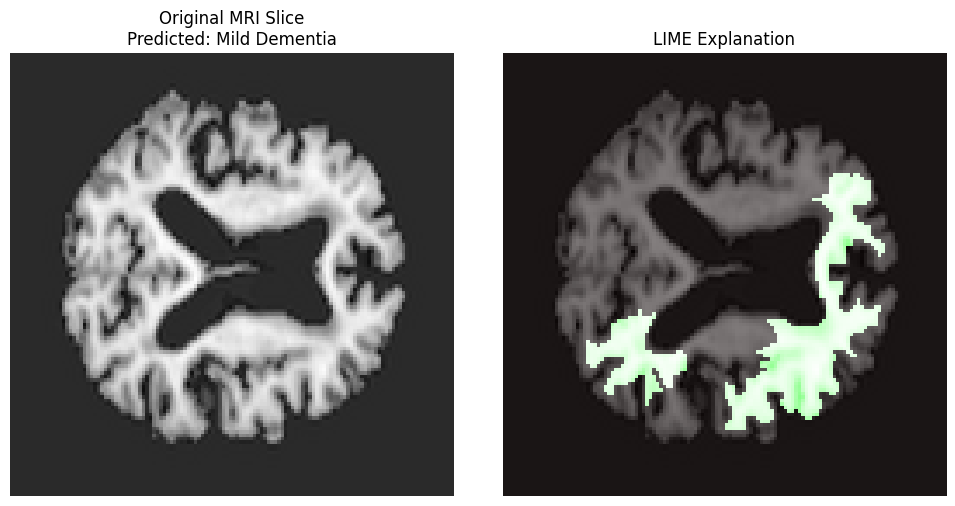


Shape of tabular data: (1, 4)
Tabular data for the patient: [87.     2.    22.     0.672]


In [ ]:
import numpy as np
import lime
from lime import lime_image
from keras.models import load_model
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize
from skimage.segmentation import slic

# Load your trained hybrid model
model = load_model('best_hybrid_model_01.h5')

# Modified predict_on_batch function
def predict_on_batch(image_batch, tabular_data):
    if len(image_batch.shape) == 3:
        image_batch = np.expand_dims(image_batch, axis=0)
    if len(image_batch.shape) == 4:
        image_batch = np.expand_dims(image_batch, axis=1)
        image_batch = np.repeat(image_batch, 10, axis=1)

    assert image_batch.shape[1:] == (10, 128, 128, 3), f"Image shape mismatch: {image_batch.shape}"

    num_samples = image_batch.shape[0]
    if tabular_data.shape[0] == 1:
        tabular_data_repeated = np.repeat(tabular_data, num_samples, axis=0)
    else:
        assert tabular_data.shape[0] == num_samples, "Tabular data samples don't match image samples"
        tabular_data_repeated = tabular_data

    assert tabular_data_repeated.shape[1] == 4, f"Tabular data shape mismatch: {tabular_data_repeated.shape}"

    predictions = model.predict([image_batch, tabular_data_repeated])
    return predictions

def get_predicted_class(predictions):
    class_names = ['Non-Demented', 'Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']
    class_index = np.argmax(predictions)
    return class_names[class_index], predictions[0]

def get_user_input():
    mri_path = input("Enter the path to your MRI image: ")
    age = float(input("Enter Age: "))
    educ = float(input("Enter Education Status: "))
    mmse = float(input("Enter MMSE score: "))
    nwbv = float(input("Enter nWBV: "))

    return mri_path, np.array([[age, educ, mmse, nwbv]])

def load_and_preprocess_image(image_path):
    nifti_img = nib.load(image_path)
    img_data = nifti_img.get_fdata()

    if len(img_data.shape) == 3:
        middle_slice = img_data.shape[2] // 2
        img_slice = img_data[:, :, middle_slice]
    else:
        img_slice = img_data

    img_normalized = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())
    img_resized = resize(img_normalized, (128, 128), anti_aliasing=True)
    img_rgb = np.stack([img_resized] * 3, axis=-1)

    return img_rgb

def main():
    mri_path, tabular_data = get_user_input()
    mri_slice_rgb = load_and_preprocess_image(mri_path)
    predictions = predict_on_batch(np.expand_dims(mri_slice_rgb, axis=0), tabular_data)
    predicted_class, class_probabilities = get_predicted_class(predictions)

    print(f"\nPredicted Class: {predicted_class}")
    print("Class Probabilities:")
    for i, prob in enumerate(['Non Demented', 'Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']):
        print(f"{prob}: {class_probabilities[i]:.4f}")

    explainer = lime_image.LimeImageExplainer()

    # Custom segmentation for smaller regions
    segmentation_fn = lambda x: slic(x, n_segments=100, compactness=10, sigma=1)

    # Explain the prediction for the MRI slice using the custom segmentation
    explanation = explainer.explain_instance(
        image=mri_slice_rgb,
        classifier_fn=lambda x: predict_on_batch(x, tabular_data),
        top_labels=4,
        hide_color=0,
        num_samples=2000,  # Increased number of samples for finer explanation
        segmentation_fn=segmentation_fn
    )

    # Get the explanation for the top predicted label
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=False,
        hide_rest=False
    )

    # Display the explanation
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(mri_slice_rgb, cmap='gray')
    plt.title(f'Original MRI Slice\nPredicted: {predicted_class}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(temp, cmap='gray')
    plt.imshow(mask, cmap=plt.cm.hot, alpha=0.5)
    plt.title('LIME Explanation')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("\nShape of tabular data:", tabular_data.shape)
    print("Tabular data for the patient:", tabular_data[0])

if __name__ == "__main__":
    main()

In [ ]:
# Install required packages
# pip install flask flask-cors nibabel tensorflow pillow nest-asyncio

from flask import Flask, request, render_template_string
from flask_cors import CORS
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
import cv2
from skimage.transform import resize
import lime
from lime import lime_image
import matplotlib.pyplot as plt
import io
import base64
from werkzeug.utils import secure_filename
import nest_asyncio

# Apply nest_asyncio for Jupyter
nest_asyncio.apply()

# Constants
IMG_SIZE = 128
NUM_SLICES = 10
CHANNELS = 3
CLASSES = ['Non Demented', 'Very Mild Dementia', 'Mild Dementia', 'Moderate Dementia']
UPLOAD_FOLDER = 'temp_uploads'
ALLOWED_EXTENSIONS = {'nii', 'nii.gz'}

# Create Flask app
app = Flask(__name__)
CORS(app)

# Configure upload folder
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
os.makedirs(UPLOAD_FOLDER, exist_ok=True)

# Load models
main_model = None
explainable_model = None

# HTML template
HTML_TEMPLATE = """
<!DOCTYPE html>
<html>
<head>
    <title>Alzheimer's Detection</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            max-width: 1200px;
            margin: 20px auto;
            padding: 20px;
            background-color: #f5f5f5;
        }
        .container {
            background-color: white;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }
        .result {
            margin-top: 20px;
            padding: 20px;
            background-color: #f8f9fa;
            border-radius: 8px;
        }
        .image-container {
            margin-top: 20px;
            background-color: white;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 2px 4px rgba(0,0,0,0.1);
        }
        img {
            width: 100%;
            max-width: 1000px;
            height: auto;
            display: block;
            margin: 0 auto;
        }
        .form-group {
            margin-bottom: 15px;
        }
        label {
            font-weight: bold;
            display: block;
            margin-bottom: 5px;
        }
        input {
            width: 100%;
            padding: 8px;
            margin-bottom: 10px;
            border: 1px solid #ddd;
            border-radius: 4px;
            box-sizing: border-box;
        }
        input[type="submit"] {
            background-color: #4CAF50;
            color: white;
            padding: 10px 20px;
            border: none;
            border-radius: 4px;
            cursor: pointer;
            width: auto;
        }
        input[type="submit"]:hover {
            background-color: #45a049;
        }
        .probability-bar {
            margin-bottom: 10px;
            background-color: #f0f0f0;
            border-radius: 4px;
            padding: 5px;
        }
        .probability-bar div {
            background-color: #4CAF50;
            height: 20px;
            border-radius: 4px;
        }
        .error {
            color: red;
            background-color: #fee;
            padding: 10px;
            border-radius: 4px;
            margin-top: 10px;
        }
    </style>
</head>
<body>
    <div class="container">
        <h2>Alzheimer's Disease Detection</h2>

        <form action="/predict" method="post" enctype="multipart/form-data">
            <div class="form-group">
                <label>MRI Scan (.nii file):</label>
                <input type="file" name="file" accept=".nii,.nii.gz" required>
            </div>

            <div class="form-group">
                <label>Age:</label>
                <input type="number" name="age" step="0.1" required>
            </div>

            <div class="form-group">
                <label>Education Status:</label>
                <input type="number" name="education" required>
            </div>

            <div class="form-group">
                <label>Mental State Examination Score:</label>
                <input type="number" name="mmse" step="0.1" required>
            </div>

            <div class="form-group">
                <label>Normalized Whole Brain Volume:</label>
                <input type="number" name="nwbv" step="0.0001" required>
            </div>

            <input type="submit" value="Predict">
        </form>

        {% if error %}
        <div class="error">{{ error }}</div>
        {% endif %}

        {% if result %}
        <div class="result">
            <h3>Results</h3>
            <p><strong>Predicted Class:</strong> {{ result.predicted_class }}</p>

            <h4>Probabilities:</h4>
            {% for class_name, prob in result.probabilities.items() %}
            <div class="probability-bar">
                <label>{{ class_name }}:</label>
                <div style="width: {{ "%.1f"|format(prob * 100) }}%"></div>
                <span>{{ "%.2f"|format(prob * 100) }}%</span>
            </div>
            {% endfor %}

            {% if result.explanation_image %}
            <div class="image-container">
                <h4>MRI Analysis:</h4>
                <img src="data:image/png;base64,{{ result.explanation_image }}"
                     alt="LIME Explanation">
            </div>
            {% endif %}
        </div>
        {% endif %}
    </div>
</body>
</html>
"""

def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS

def load_models():
    """Load both models"""
    global main_model
    try:
        main_model = tf.keras.models.load_model('best_hybrid_model_01.h5')
        print("Models loaded successfully")
    except Exception as e:
        print(f"Error loading models: {str(e)}")

def load_and_preprocess_image(image_path):
    """Load and preprocess image matching your implementation"""
    # Load the NIfTI file
    nifti_img = nib.load(image_path)

    # Get the data as a numpy array
    img_data = nifti_img.get_fdata()

    # If the image is 3D, take a middle slice
    if len(img_data.shape) == 3:
        middle_slice = img_data.shape[2] // 2
        img_slice = img_data[:, :, middle_slice]
    else:
        img_slice = img_data

    # Normalize the image to 0-1 range
    img_normalized = (img_slice - img_slice.min()) / (img_slice.max() - img_slice.min())

    # Resize to 128x128
    img_resized = resize(img_normalized, (128, 128), anti_aliasing=True)

    # Convert to RGB (3 channels)
    img_rgb = np.stack([img_resized] * 3, axis=-1)

    return img_rgb

def predict_on_batch(image_batch, tabular_data):
    """Prediction function matching your implementation"""
    # Ensure image_batch has the correct shape (None, 10, 128, 128, 3)
    if len(image_batch.shape) == 3:  # LIME passes a single image (128, 128, 3)
        image_batch = np.expand_dims(image_batch, axis=0)  # Shape to (1, 128, 128, 3)
    if len(image_batch.shape) == 4:  # Shape is (N, 128, 128, 3)
        image_batch = np.expand_dims(image_batch, axis=1)  # Shape to (N, 1, 128, 128, 3)
        image_batch = np.repeat(image_batch, 10, axis=1)  # Expand to (N, 10, 128, 128, 3)

    # Repeat tabular data to match the number of image samples
    num_samples = image_batch.shape[0]
    if tabular_data.shape[0] == 1:
        tabular_data_repeated = np.repeat(tabular_data, num_samples, axis=0)
    else:
        tabular_data_repeated = tabular_data

    # Make predictions
    predictions = main_model.predict([image_batch, tabular_data_repeated])
    return predictions

def generate_lime_explanation(model, image, tabular_data):
    """Generate LIME explanation matching your implementation"""
    explainer = lime_image.LimeImageExplainer()

    # Create the classifier function for LIME
    classifier_fn = lambda x: predict_on_batch(x, tabular_data)

    # Generate explanation
    explanation = explainer.explain_instance(
        image=image,
        classifier_fn=classifier_fn,
        top_labels=4,
        hide_color=0,
        num_samples=1000
    )

    # Get the explanation for the top predicted label
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],
        positive_only=False,
        hide_rest=False
    )

    # Get prediction for the title
    predictions = predict_on_batch(np.expand_dims(image, axis=0), tabular_data)
    predicted_class = CLASSES[np.argmax(predictions[0])]

    # Create visualization
    plt.figure(figsize=(10, 5))

    # Original image with prediction
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original MRI Slice\nPredicted: {predicted_class}')
    plt.axis('off')

    # LIME explanation
    plt.subplot(1, 2, 2)
    plt.imshow(temp, cmap='gray')
    plt.imshow(mask, cmap=plt.cm.hot, alpha=0.5)
    plt.title('LIME Explanation')
    plt.axis('off')

    plt.tight_layout()

    # Save to buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    plt.close()
    buf.seek(0)

    return base64.b64encode(buf.getvalue()).decode('utf-8')

@app.route('/')
def home():
    return render_template_string(HTML_TEMPLATE)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        if main_model is None:
            load_models()

        if 'file' not in request.files:
            return render_template_string(HTML_TEMPLATE, error="No file uploaded")
        file = request.files['file']

        try:
            age = float(request.form['age'])
            education = int(request.form['education'])
            mmse = float(request.form['mmse'])
            nwbv = float(request.form['nwbv'])
        except:
            return render_template_string(HTML_TEMPLATE, error="Invalid input values")

        filename = secure_filename(file.filename)
        filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(filepath)

        try:
            # Load and preprocess image
            mri_slice_rgb = load_and_preprocess_image(filepath)

            # Prepare tabular data
            tabular_data = np.array([[age, education, mmse, nwbv]])

            # Get predictions
            predictions = predict_on_batch(np.expand_dims(mri_slice_rgb, axis=0), tabular_data)
            predicted_class = CLASSES[np.argmax(predictions[0])]
            probabilities = {
                class_name: float(prob)
                for class_name, prob in zip(CLASSES, predictions[0])
            }

            # Generate LIME explanation
            explanation_image = generate_lime_explanation(
                main_model,
                mri_slice_rgb,
                tabular_data
            )

            result = {
                'predicted_class': predicted_class,
                'probabilities': probabilities,
                'explanation_image': explanation_image
            }

            return render_template_string(HTML_TEMPLATE, result=result)

        finally:
            if os.path.exists(filepath):
                os.remove(filepath)

    except Exception as e:
        print(f"Error in predict route: {str(e)}")
        return render_template_string(HTML_TEMPLATE, error=str(e))

if __name__ == '__main__':
    # Load models at startup
    load_models()
    # Run the app
    from werkzeug.serving import run_simple
    run_simple('127.0.0.1', 5000, app, use_debugger=True, use_reloader=False)

 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


Models loaded successfully


127.0.0.1 - - [27/Oct/2024 12:16:49] "GET / HTTP/1.1" 200 -


1/1 [==============================] - 0s 475ms/step


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


  1%|▊                                                                               | 10/1000 [00:03<05:09,  3.20it/s]

1/1 [==============================] - 3s 3s/step


  2%|█▌                                                                              | 20/1000 [00:06<05:14,  3.12it/s]

1/1 [==============================] - 3s 3s/step


  3%|██▍                                                                             | 30/1000 [00:09<05:08,  3.14it/s]

1/1 [==============================] - 3s 3s/step


  4%|███▏                                                                            | 40/1000 [00:12<05:06,  3.13it/s]

1/1 [==============================] - 3s 3s/step


  5%|████                                                                            | 50/1000 [00:15<05:00,  3.16it/s]

1/1 [==============================] - 3s 3s/step


  6%|████▊                                                                           | 60/1000 [00:19<04:58,  3.15it/s]

1/1 [==============================] - 3s 3s/step


  7%|█████▌                                                                          | 70/1000 [00:22<04:53,  3.17it/s]

1/1 [==============================] - 3s 3s/step


  8%|██████▍                                                                         | 80/1000 [00:25<04:49,  3.18it/s]

1/1 [==============================] - 3s 3s/step


  9%|███████▏                                                                        | 90/1000 [00:28<04:51,  3.12it/s]

1/1 [==============================] - 3s 3s/step


 10%|███████▉                                                                       | 100/1000 [00:31<04:49,  3.11it/s]

1/1 [==============================] - 3s 3s/step


 11%|████████▋                                                                      | 110/1000 [00:35<04:46,  3.11it/s]

1/1 [==============================] - 3s 3s/step


 12%|█████████▍                                                                     | 120/1000 [00:38<04:46,  3.07it/s]

1/1 [==============================] - 3s 3s/step


 13%|██████████▎                                                                    | 130/1000 [00:41<04:48,  3.01it/s]

1/1 [==============================] - 3s 3s/step


 14%|███████████                                                                    | 140/1000 [00:45<04:48,  2.99it/s]

1/1 [==============================] - 3s 3s/step


 15%|███████████▊                                                                   | 150/1000 [00:48<04:48,  2.95it/s]

1/1 [==============================] - 3s 3s/step


 16%|████████████▋                                                                  | 160/1000 [00:52<04:45,  2.94it/s]

1/1 [==============================] - 3s 3s/step


 17%|█████████████▍                                                                 | 170/1000 [00:55<04:40,  2.96it/s]

1/1 [==============================] - 3s 3s/step


 18%|██████████████▏                                                                | 180/1000 [00:58<04:36,  2.96it/s]

1/1 [==============================] - 3s 3s/step


 19%|███████████████                                                                | 190/1000 [01:02<04:34,  2.95it/s]

1/1 [==============================] - 3s 3s/step


 20%|███████████████▊                                                               | 200/1000 [01:05<04:32,  2.94it/s]

1/1 [==============================] - 3s 3s/step


 21%|████████████████▌                                                              | 210/1000 [01:09<04:29,  2.93it/s]

1/1 [==============================] - 3s 3s/step


 22%|█████████████████▍                                                             | 220/1000 [01:12<04:29,  2.90it/s]

1/1 [==============================] - 4s 4s/step


 23%|██████████████████▏                                                            | 230/1000 [01:16<04:32,  2.83it/s]

1/1 [==============================] - 4s 4s/step


 24%|██████████████████▉                                                            | 240/1000 [01:20<04:30,  2.80it/s]

1/1 [==============================] - 3s 3s/step


 25%|███████████████████▊                                                           | 250/1000 [01:23<04:23,  2.85it/s]

1/1 [==============================] - 3s 3s/step


 26%|████████████████████▌                                                          | 260/1000 [01:26<04:17,  2.88it/s]

1/1 [==============================] - 3s 3s/step


 27%|█████████████████████▎                                                         | 270/1000 [01:30<04:14,  2.87it/s]

1/1 [==============================] - 4s 4s/step


 28%|██████████████████████                                                         | 280/1000 [01:34<04:15,  2.82it/s]

1/1 [==============================] - 3s 3s/step


 29%|██████████████████████▉                                                        | 290/1000 [01:37<04:12,  2.82it/s]

1/1 [==============================] - 4s 4s/step


 30%|███████████████████████▋                                                       | 300/1000 [01:41<04:10,  2.79it/s]

1/1 [==============================] - 4s 4s/step


 31%|████████████████████████▍                                                      | 310/1000 [01:45<04:11,  2.75it/s]

1/1 [==============================] - 3s 3s/step


 32%|█████████████████████████▎                                                     | 320/1000 [01:48<04:05,  2.77it/s]

1/1 [==============================] - 3s 3s/step


 33%|██████████████████████████                                                     | 330/1000 [01:52<04:00,  2.79it/s]

1/1 [==============================] - 3s 3s/step


 34%|██████████████████████████▊                                                    | 340/1000 [01:55<03:55,  2.80it/s]

1/1 [==============================] - 3s 3s/step


 35%|███████████████████████████▋                                                   | 350/1000 [01:59<03:50,  2.82it/s]

1/1 [==============================] - 4s 4s/step


 36%|████████████████████████████▍                                                  | 360/1000 [02:02<03:47,  2.81it/s]

1/1 [==============================] - 4s 4s/step


 37%|█████████████████████████████▏                                                 | 370/1000 [02:06<03:45,  2.79it/s]

1/1 [==============================] - 4s 4s/step


 38%|██████████████████████████████                                                 | 380/1000 [02:10<03:42,  2.78it/s]

1/1 [==============================] - 4s 4s/step


 39%|██████████████████████████████▊                                                | 390/1000 [02:13<03:40,  2.77it/s]

1/1 [==============================] - 4s 4s/step


 40%|███████████████████████████████▌                                               | 400/1000 [02:17<03:37,  2.76it/s]

1/1 [==============================] - 3s 3s/step


 41%|████████████████████████████████▍                                              | 410/1000 [02:20<03:31,  2.79it/s]

1/1 [==============================] - 3s 3s/step


 42%|█████████████████████████████████▏                                             | 420/1000 [02:24<03:27,  2.80it/s]

1/1 [==============================] - 3s 3s/step


 43%|█████████████████████████████████▉                                             | 430/1000 [02:27<03:23,  2.81it/s]

1/1 [==============================] - 4s 4s/step


 44%|██████████████████████████████████▊                                            | 440/1000 [02:31<03:19,  2.81it/s]

1/1 [==============================] - 3s 3s/step


 45%|███████████████████████████████████▌                                           | 450/1000 [02:35<03:15,  2.81it/s]

1/1 [==============================] - 3s 3s/step


 46%|████████████████████████████████████▎                                          | 460/1000 [02:38<03:11,  2.83it/s]

1/1 [==============================] - 3s 3s/step


 47%|█████████████████████████████████████▏                                         | 470/1000 [02:42<03:07,  2.82it/s]

1/1 [==============================] - 4s 4s/step


 48%|█████████████████████████████████████▉                                         | 480/1000 [02:45<03:05,  2.80it/s]

1/1 [==============================] - 4s 4s/step


 49%|██████████████████████████████████████▋                                        | 490/1000 [02:49<03:01,  2.80it/s]

1/1 [==============================] - 3s 3s/step


 50%|███████████████████████████████████████▌                                       | 500/1000 [02:52<02:57,  2.81it/s]

1/1 [==============================] - 3s 3s/step


 51%|████████████████████████████████████████▎                                      | 510/1000 [02:56<02:53,  2.82it/s]

1/1 [==============================] - 3s 3s/step


 52%|█████████████████████████████████████████                                      | 520/1000 [02:59<02:50,  2.82it/s]

1/1 [==============================] - 3s 3s/step


 53%|█████████████████████████████████████████▊                                     | 530/1000 [03:03<02:46,  2.82it/s]

1/1 [==============================] - 3s 3s/step


 54%|██████████████████████████████████████████▋                                    | 540/1000 [03:06<02:43,  2.82it/s]

1/1 [==============================] - 3s 3s/step


 55%|███████████████████████████████████████████▍                                   | 550/1000 [03:10<02:39,  2.82it/s]

1/1 [==============================] - 4s 4s/step


 56%|████████████████████████████████████████████▏                                  | 560/1000 [03:14<02:37,  2.80it/s]

1/1 [==============================] - 4s 4s/step


 57%|█████████████████████████████████████████████                                  | 570/1000 [03:17<02:34,  2.78it/s]

1/1 [==============================] - 4s 4s/step


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [03:21<02:30,  2.79it/s]

1/1 [==============================] - 3s 3s/step


 59%|██████████████████████████████████████████████▌                                | 590/1000 [03:24<02:26,  2.80it/s]

1/1 [==============================] - 4s 4s/step


 60%|███████████████████████████████████████████████▍                               | 600/1000 [03:28<02:23,  2.80it/s]

1/1 [==============================] - 4s 4s/step


 61%|████████████████████████████████████████████████▏                              | 610/1000 [03:32<02:19,  2.80it/s]

1/1 [==============================] - 4s 4s/step


 62%|████████████████████████████████████████████████▉                              | 620/1000 [03:35<02:15,  2.79it/s]

1/1 [==============================] - 4s 4s/step


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [03:39<02:12,  2.79it/s]

1/1 [==============================] - 4s 4s/step


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [03:42<02:09,  2.78it/s]

1/1 [==============================] - 4s 4s/step


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [03:46<02:06,  2.77it/s]

1/1 [==============================] - 4s 4s/step


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [03:50<02:04,  2.73it/s]

1/1 [==============================] - 4s 4s/step


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [03:53<02:01,  2.72it/s]

1/1 [==============================] - 4s 4s/step


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [03:57<01:58,  2.71it/s]

1/1 [==============================] - 4s 4s/step


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [04:01<01:54,  2.70it/s]

1/1 [==============================] - 4s 4s/step


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [04:05<01:51,  2.70it/s]

1/1 [==============================] - 4s 4s/step


 71%|████████████████████████████████████████████████████████                       | 710/1000 [04:08<01:47,  2.70it/s]

1/1 [==============================] - 4s 4s/step


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [04:12<01:44,  2.69it/s]

1/1 [==============================] - 4s 4s/step


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [04:16<01:41,  2.67it/s]

1/1 [==============================] - 4s 4s/step


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [04:20<01:39,  2.62it/s]

1/1 [==============================] - 4s 4s/step


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [04:24<01:35,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [04:28<01:32,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [04:32<01:29,  2.58it/s]

1/1 [==============================] - 4s 4s/step


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [04:36<01:25,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [04:40<01:22,  2.54it/s]

1/1 [==============================] - 4s 4s/step


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [04:44<01:19,  2.51it/s]

1/1 [==============================] - 4s 4s/step


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [04:48<01:15,  2.52it/s]

1/1 [==============================] - 4s 4s/step


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [04:51<01:10,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [04:55<01:06,  2.57it/s]

1/1 [==============================] - 4s 4s/step


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [04:59<01:01,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [05:03<00:57,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [05:07<00:53,  2.61it/s]

1/1 [==============================] - 4s 4s/step


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [05:10<00:49,  2.62it/s]

1/1 [==============================] - 4s 4s/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [05:14<00:45,  2.62it/s]

1/1 [==============================] - 4s 4s/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [05:18<00:42,  2.60it/s]

1/1 [==============================] - 4s 4s/step


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [05:22<00:38,  2.63it/s]

1/1 [==============================] - 4s 4s/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [05:25<00:33,  2.66it/s]

1/1 [==============================] - 4s 4s/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [05:29<00:29,  2.68it/s]

1/1 [==============================] - 4s 4s/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [05:33<00:26,  2.69it/s]

1/1 [==============================] - 4s 4s/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [05:36<00:22,  2.71it/s]

1/1 [==============================] - 4s 4s/step


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [05:40<00:18,  2.72it/s]

1/1 [==============================] - 4s 4s/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [05:44<00:14,  2.71it/s]

1/1 [==============================] - 4s 4s/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [05:47<00:11,  2.70it/s]

1/1 [==============================] - 4s 4s/step


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [05:51<00:07,  2.71it/s]

1/1 [==============================] - 4s 4s/step


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [05:55<00:03,  2.71it/s]

1/1 [==============================] - 4s 4s/step


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:59<00:00,  2.78it/s]


1/1 [==============================] - 0s 396ms/step


127.0.0.1 - - [27/Oct/2024 12:23:07] "POST /predict HTTP/1.1" 200 -
